In [47]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

import pathlib
import os

import numpy as np

import matplotlib.pyplot as plt

In [22]:
data_dir = pathlib.Path(f'{os.getenv("HOME")}/code/data')

In [23]:
image_count = len(list(data_dir.glob('*/*.npy')))

In [24]:
image_count

144000

In [25]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.npy'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [26]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/vincent_moreau/code/data/nine/AF7_5824_9.npy'
b'/home/vincent_moreau/code/data/nothing/AF8_18733_10.npy'
b'/home/vincent_moreau/code/data/nothing/TP9_27467_10.npy'
b'/home/vincent_moreau/code/data/nothing/TP9_5957_10.npy'
b'/home/vincent_moreau/code/data/zero/AF7_17308_0.npy'


In [27]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != ".ipynb_checkpoints"]))
print(class_names)

['eight' 'five' 'four' 'nine' 'nothing' 'one' 'seven' 'six' 'three' 'two'
 'zero']


In [37]:
CONFIG = dict(test_split=.3,
              batch_size=32,
              img_height = 192,
              img_width = 256,
              n_channels = 3,
              n_classes = len(class_names)
              )

AUTOTUNE = tf.data.AUTOTUNE

In [29]:
val_size = int(image_count * CONFIG['test_split'])
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [30]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [31]:
def decode_array(img):
    array = tf.numpy_function(np.load, [img], tf.uint8)
    return array

In [32]:
def process_path(file_path):
    label = get_label(file_path)
    array = decode_array(file_path)
    return array, label

In [33]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(CONFIG['batch_size'])
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [34]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

nothing


2022-09-05 19:31:58.680655: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


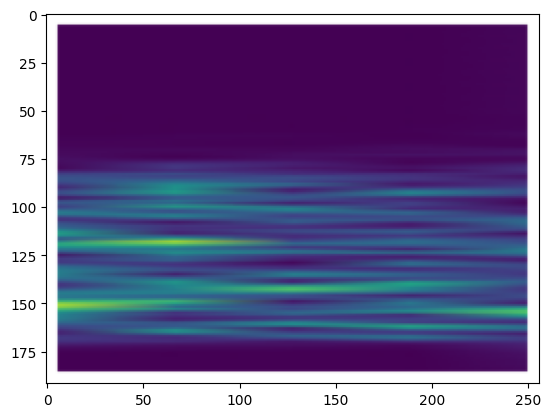

In [36]:
for image, label in train_ds.take(1):
    plt.imshow(image[0])
    print(class_names[label[0].numpy()])

In [60]:
def get_model_vanilla():
    
    input_shape = (CONFIG['img_height'], CONFIG['img_width'], CONFIG['n_channels'])
    
    model = tf.keras.Sequential([
        
        tf.keras.layers.Input(shape=input_shape),
        
        tf.keras.layers.Rescaling(1./255),
        
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(32, 2, activation='relu'),
        
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(32, activation='relu'),
        
        tf.keras.layers.Dropout(.3),

        tf.keras.layers.Dense(32, activation='relu'),
        
        tf.keras.layers.Dense(units=CONFIG['n_classes'], activation='softmax')
    ])
    return model

In [61]:
def get_model_custom():
    model = Sequential()

    input_shape = (CONFIG['img_height'], CONFIG['img_width'], CONFIG['n_channels'])
    
    model.add(layers.Input(shape=input_shape)),
    
    model.add(layers.Rescaling(1./255)),
    
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (2, 2), activation='relu'))
    
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units=64, activation='relu'))
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(units=32, activation='relu'))

    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(units=CONFIG['n_classes'], activation='softmax'))
    return model

def compile_model(model):
    model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [62]:
model = get_model_vanilla()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 192, 256, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 188, 252, 16)      1216      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 94, 126, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 92, 124, 32)       4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 46, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 61, 32)       

In [63]:
model = compile_model(model)

In [64]:
es = EarlyStopping(patience=20,
                   restore_best_weights=True)

In [65]:
model.fit(train_ds,
          validation_data=val_ds,
          callbacks = [es],
          epochs=500)

Epoch 1/500
  71/3150 [..............................] - ETA: 40:05 - loss: 1.9527 - accuracy: 0.4930

KeyboardInterrupt: 